In [180]:
##### Importing Relevant Libraries ######
#########################################

import pandas as pd
import scipy.stats 
import time
import numpy as np
import os
import seaborn as sns
from sklearn.svm import SVC
import pickle ### helps storing data in pickle files
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier           ### helps fitting a decision tree
from sklearn.ensemble import RandomForestClassifier### models from sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score 
from sklearn.model_selection import cross_val_score## model evaluation metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
import warnings

import warnings;
warnings.filterwarnings('ignore');

In [40]:
%matplotlib inline

In [153]:
data = pd.read_csv('train_PDjVQMB.csv')  ## Loads the data

In [42]:
data.shape #finding rows and columns of the data. 6650 rows and 11 columns

(6650, 11)

In [43]:
data.head()  # Having a brief look at the data
#### Scaling needs to be done as scale is different for most of the variables

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [44]:
#### Distribution of target class ####

data['Is_Churn'].value_counts()

#### There is class imbalance in my dataset. We might ask for more observations for class 1.

#### if the distribution is 80%-20% - generally not a major concern.
#### if the distribution is between 80%-20% and 95%-5% -  area of slight concern..
#### if the distribution is less than 95-5% - we should get concerned - expect that your model might be a bad modeldata['Is_Churn'].value_counts() 
##### There is class imbalance in my data
#### We will have to do something to reduce the imbalance

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [45]:
data.info() ### prints out information regarding columns in the data

#### Insight #####
####################
###########  Out of 11 columns 5 are non numeric. Except ID we will convert rest into numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


In [46]:
print(data.isnull().sum()) #We do not see any missing values in any
#of the columns of our dataset.

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64


In [47]:
data.skew() # acceptable range is +/-0.5

Age                   0.555171
Balance               0.464460
Vintage               0.021421
Transaction_Status   -0.063204
Credit_Card          -0.696287
Is_Churn              1.275912
dtype: float64

Here we see that Vintage,Transaction_status are skewed and would need to be treated if required. We ignore the Is_Churn variablke as it is out target variable.

###### Data visualisation

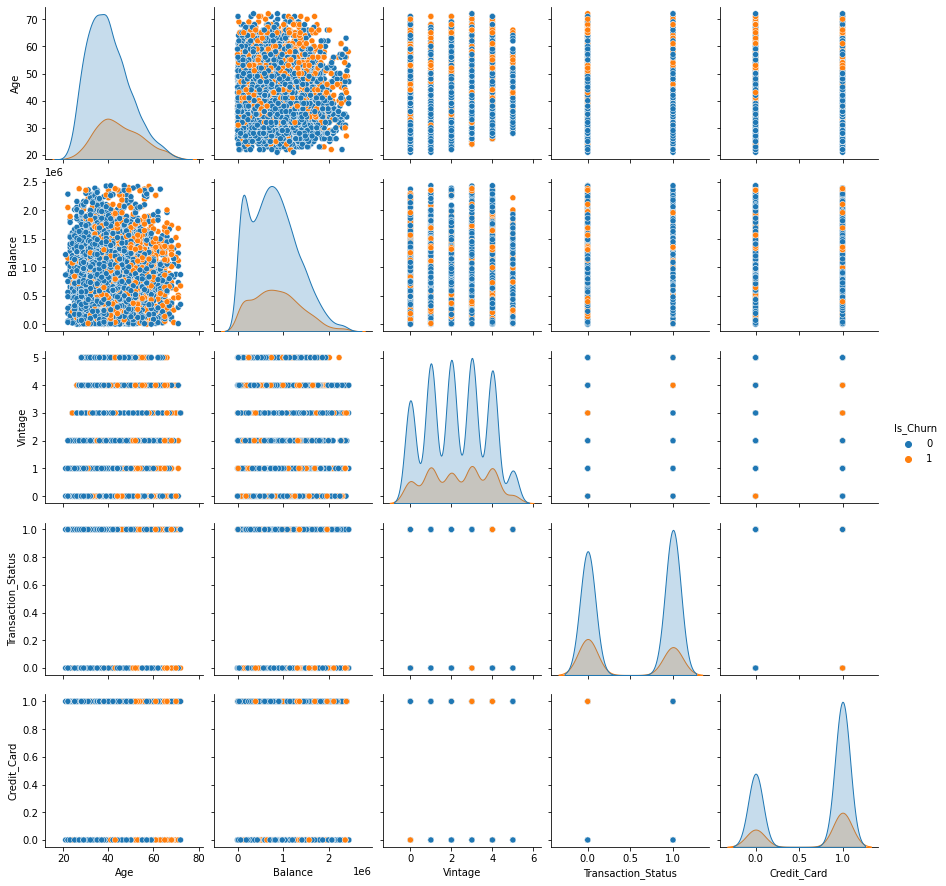

In [48]:
sns.pairplot(data,hue='Is_Churn')

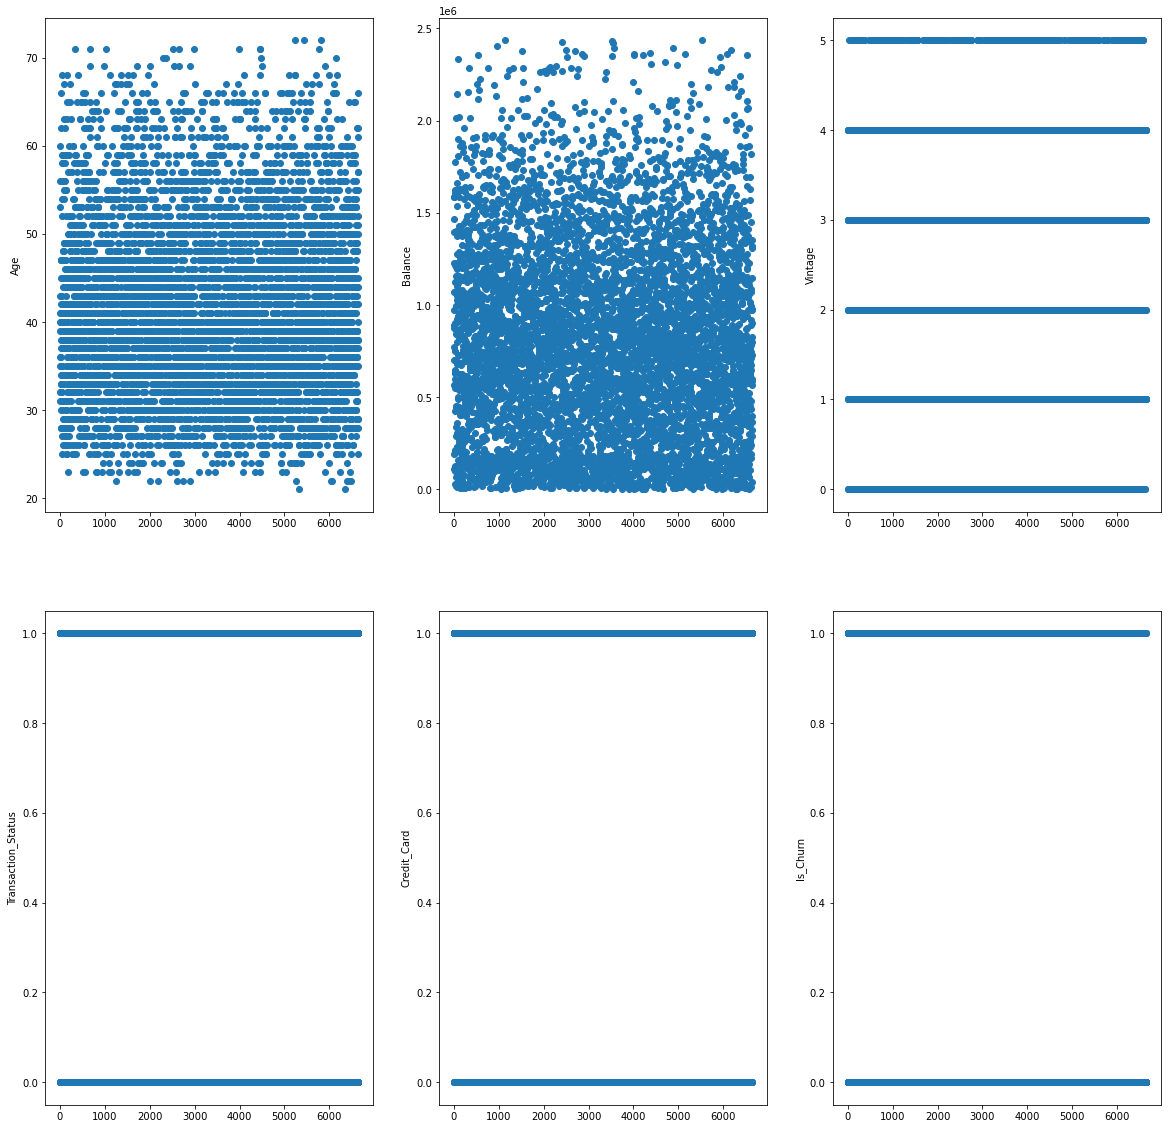

In [49]:
#### Visualizing numeric columns ######

numeric_cols = data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 2
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index)
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1
        
###### Insights #####
#####################  No extreme outliers seem to be present in our data

<AxesSubplot:xlabel='Balance', ylabel='Density'>

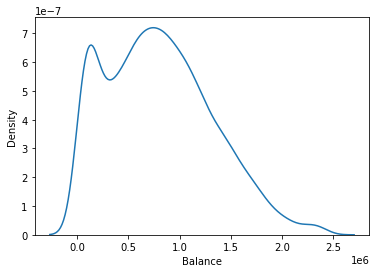

In [50]:
sns.distplot(data['Balance'],hist = False)

<AxesSubplot:xlabel='Age', ylabel='Density'>

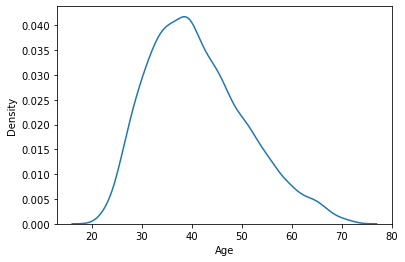

In [51]:
sns.distplot(data['Age'],hist = False) 

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

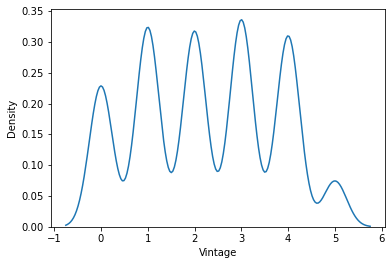

In [52]:
sns.distplot(data['Vintage'],hist = False)  #We have less customers who are associated with the bank for 5 years

<AxesSubplot:xlabel='Transaction_Status', ylabel='Density'>

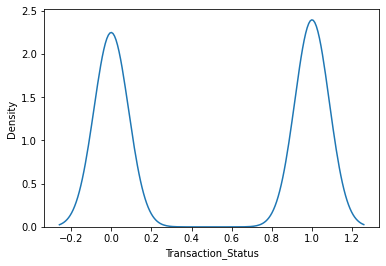

In [53]:
sns.distplot(data['Transaction_Status'],hist = False)   

<AxesSubplot:xlabel='Is_Churn', ylabel='Density'>

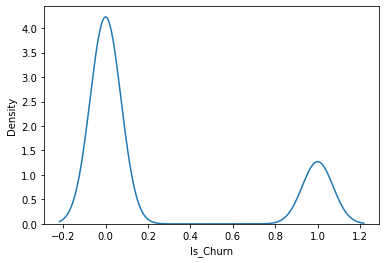

In [54]:
sns.distplot(data['Is_Churn'],hist = False)  # The target vaiable Is_Churn has an 
##############imbalance and we have more data for 0 class


<AxesSubplot:xlabel='Credit_Card', ylabel='Density'>

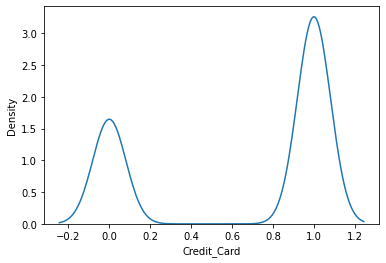

In [55]:
sns.distplot(data['Credit_Card'],hist = False)  #customers with credit card are more than those not having credit card

<AxesSubplot:xlabel='Gender', ylabel='count'>

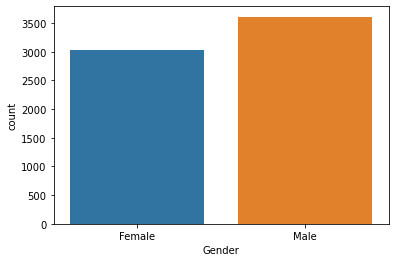

In [56]:
sns.countplot(x='Gender',data=data)  # In our data male count is slightly more than female

<AxesSubplot:xlabel='Income', ylabel='count'>

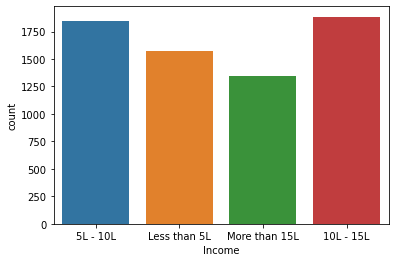

In [57]:
sns.countplot(x='Income',data=data)  

<AxesSubplot:xlabel='Product_Holdings', ylabel='count'>

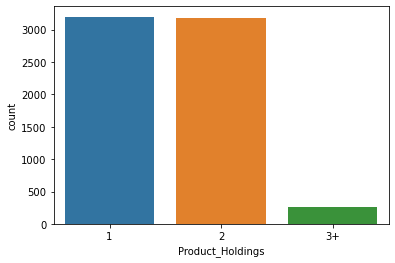

In [58]:
sns.countplot(x='Product_Holdings',data=data) # customers holding more than 3 products are very few

<AxesSubplot:xlabel='Credit_Category', ylabel='count'>

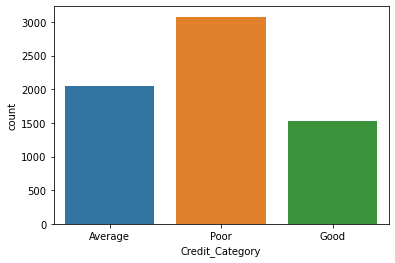

In [59]:
sns.countplot(x='Credit_Category',data=data)  ### poor category data is maximum and good category is minimum

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

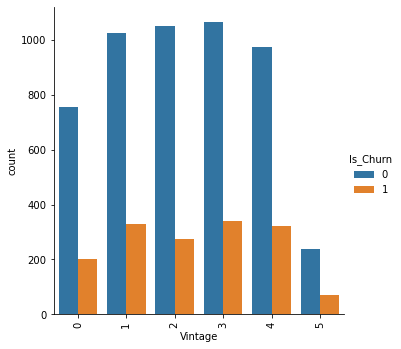

In [60]:
sns.catplot(x='Vintage',hue='Is_Churn',kind='count',data=data,height=5)
plt.xticks(rotation=90)

(array([0, 1, 2]),
 [Text(0, 0, 'Average'), Text(1, 0, 'Poor'), Text(2, 0, 'Good')])

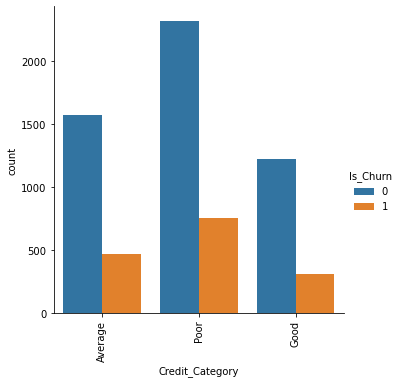

In [61]:
sns.catplot(x='Credit_Category',hue='Is_Churn',kind='count',data=data,height=5)
plt.xticks(rotation=90) 

(array([0, 1, 2, 3]),
 [Text(0, 0, '5L - 10L'),
  Text(1, 0, 'Less than 5L'),
  Text(2, 0, 'More than 15L'),
  Text(3, 0, '10L - 15L')])

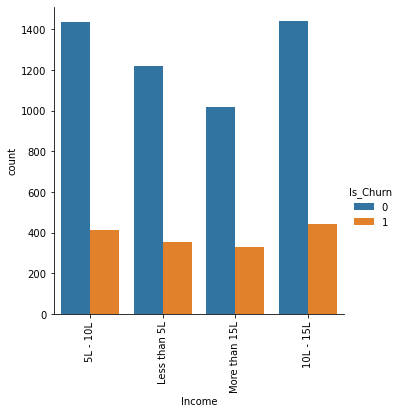

In [62]:
sns.catplot(x='Income',hue='Is_Churn',kind='count',data=data,height=5)
plt.xticks(rotation=90)

In [63]:
##### Describing categorical columns #####

cat_data = data.select_dtypes(include = np.object)

column_names = list(cat_data.columns)

for column in column_names:
    print('Column ', column)
    print('Number of unique elements ', cat_data[column].nunique())
    print('***************\n')
    
##### Insights ######
#####################
###Since ID column  has 6650 rows, it seems irrelevant towards the prediction. we can drop it

Column  ID
Number of unique elements  6650
***************

Column  Gender
Number of unique elements  2
***************

Column  Income
Number of unique elements  4
***************

Column  Product_Holdings
Number of unique elements  3
***************

Column  Credit_Category
Number of unique elements  3
***************



In [64]:
data.describe() #to find out 5 point summary of the data. Mean,median, quartiles and min , max of each numeric column. 
################As seen before there do not seem to be outliers in the data

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000



##### Finding out the correlation between the various variables and also the correlation of each variable with the target variable

In [65]:
corrmat=data.corr()

<AxesSubplot:>

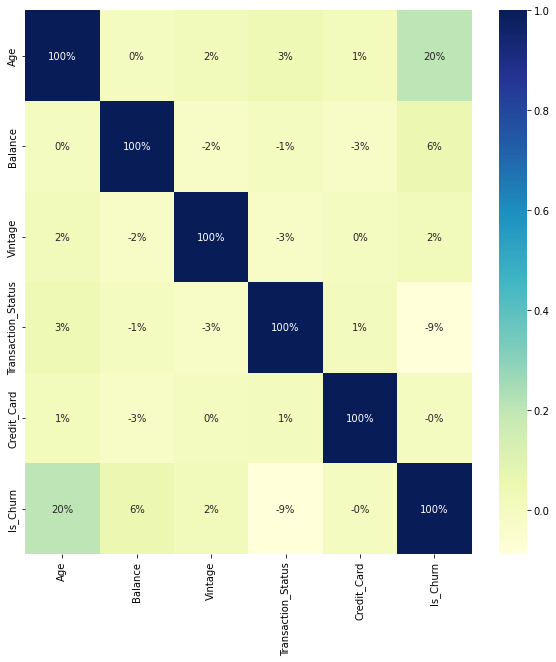

In [66]:

import  seaborn as sns 
plt.figure(figsize=[10,10])
sns.heatmap(corrmat,annot=True,cmap='YlGnBu',fmt='.0%')

As we can see there is a very less correlation between the variables. Maximum correlation is only 20% that too between age and is_churn variable. We need to explore this more.

In [67]:
a = pd.crosstab(data['Income'], data['Is_Churn'])
print(a)
a['percentage'] = a[0]/(a[0]+a[1])
a #########We can see that income is not having any impact on the Is_Churn variable as was also clear from correlation

Is_Churn          0    1
Income                  
10L - 15L      1441  444
5L - 10L       1435  412
Less than 5L   1219  354
More than 15L  1018  327


Is_Churn,0,1,percentage
Income,,,
10L - 15L,1441,444,0.764456
5L - 10L,1435,412,0.776936
Less than 5L,1219,354,0.774952
More than 15L,1018,327,0.756877


In [68]:
a = pd.crosstab(data['Credit_Card'], data['Is_Churn'])
print(a)
a['percentage'] = a[0]/(a[0]+a[1])
a #########We can see that having a credit card is not having any impact on the Is_Churn variable as was also clear from correlation

Is_Churn        0     1
Credit_Card            
0            1715   517
1            3398  1020


Is_Churn,0,1,percentage
Credit_Card,,,
0,1715,517,0.768369
1,3398,1020,0.769126


In [69]:
a = pd.crosstab(data['Credit_Category'], data['Is_Churn'])
print(a)
a['percentage'] = a[0]/(a[0]+a[1])
a #########We can see that having a credit card is not having any impact on the Is_Churn variable as was also clear from correlation

Is_Churn            0    1
Credit_Category           
Average          1572  471
Good             1220  311
Poor             2321  755


Is_Churn,0,1,percentage
Credit_Category,,,
Average,1572,471,0.769457
Good,1220,311,0.796865
Poor,2321,755,0.754551


#### Data Preprocessing

In [72]:
print('The shape of the data before preprocessing ', data.shape)

The shape of the data before preprocessing  (6650, 11)


In [73]:
data.drop(['ID'],axis=1,inplace=True)  ## removes specified columns as the number is different for each row and has no impact on the target variable

In [74]:
data.shape


(6650, 10)

In [75]:
data['Age'].nunique()  #finding number of unique values in age column

52

In [76]:
print(data['Income'].unique()) #finding  unique values in income column

['5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L']


In [77]:
#converting income column in numeric by creating dummy columns
le = preprocessing.LabelEncoder() 
data['Income'] = le.fit_transform(data['Income'])
data['Income']

0       1
1       2
2       3
3       3
4       3
       ..
6645    1
6646    1
6647    2
6648    0
6649    3
Name: Income, Length: 6650, dtype: int32

In [78]:
print(data['Credit_Category'].unique()) #finding number of unique values in Credit_Category column

['Average' 'Poor' 'Good']


In [79]:
#converting credit category column in numeric by using label encoder
data['Credit_Category'] = le.fit_transform(data['Credit_Category'])
data['Credit_Category']

0       0
1       2
2       2
3       2
4       1
       ..
6645    2
6646    0
6647    2
6648    2
6649    1
Name: Credit_Category, Length: 6650, dtype: int32

In [80]:
data['Gender'].unique()   #finding  unique values in Gender column

array(['Female', 'Male'], dtype=object)

In [81]:
#converting gender column in nymeric by creating dummy columns
gender_dummies = pd.get_dummies(data['Gender'], drop_first=False, prefix = 'Gender')

data.drop(['Gender'],axis=1,inplace=True)

data = pd.concat([data,gender_dummies],axis=1)


In [82]:
data.shape

(6650, 11)

In [83]:
data.head()

,Age,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Gender_Female,Gender_Male
0,36,1,563266.44,4,0,1,0,0,1,1,0
1,53,2,875572.11,2,1,1,1,2,0,1,0
2,35,3,701607.06,2,1,2,0,2,0,1,0
3,43,3,1393922.16,0,1,2,1,2,1,1,0
4,39,3,893146.23,1,1,1,1,1,1,1,0


In [84]:
print(data['Product_Holdings'].value_counts())  ######Seeing that 3+ value has made this column as object

1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64


In [85]:
#Capping the value of product holdings to 3 and creating dummy variables for product holdings
data.loc[data['Product_Holdings']== '3+','Product_Holdings'] = '3'

Product_Holdings_data = pd.get_dummies(data['Product_Holdings'],prefix ='Product_Holdings')

data.drop(['Product_Holdings'],axis=1,inplace=True)

data = pd.concat([data,Product_Holdings_data],axis=1)

In [86]:
data.shape  #########shape of data after preprocessing. we have increased columns to 12

(6650, 13)

In [87]:
data.head()  ##########few new dummy columns have been created

,Age,Income,Balance,Vintage,Transaction_Status,Credit_Card,Credit_Category,Is_Churn,Gender_Female,Gender_Male,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3
0,36,1,563266.44,4,0,0,0,1,1,0,1,0,0
1,53,2,875572.11,2,1,1,2,0,1,0,1,0,0
2,35,3,701607.06,2,1,0,2,0,1,0,0,1,0
3,43,3,1393922.16,0,1,1,2,1,1,0,0,1,0
4,39,3,893146.23,1,1,1,1,1,1,0,1,0,0


In [88]:
data.dtypes # now we can see all the features are in numeric form

Age                     int64
Income                  int32
Balance               float64
Vintage                 int64
Transaction_Status      int64
Credit_Card             int64
Credit_Category         int32
Is_Churn                int64
Gender_Female           uint8
Gender_Male             uint8
Product_Holdings_1      uint8
Product_Holdings_2      uint8
Product_Holdings_3      uint8
dtype: object

Now as we can see that the income and age values are not in the same scale as rest of the variables. So we need to scale these two variables before we start building our model.

In [89]:
#scaling age and income variables
#list for cols to scale
cols_to_scale = ['Age','Balance']

#create and fit scaler
scaler = StandardScaler()
scaler.fit(data[cols_to_scale])

#scale selected data
data[cols_to_scale] = scaler.transform(data[cols_to_scale])
data.head()

,Age,Income,Balance,Vintage,Transaction_Status,Credit_Card,Credit_Category,Is_Churn,Gender_Female,Gender_Male,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3
0,-0.529707,1,-0.467949,4,0,0,0,1,1,0,1,0,0
1,1.225581,2,0.137628,2,1,1,2,0,1,0,1,0,0
2,-0.632960,3,-0.199700,2,1,0,2,0,1,0,0,1,0
3,0.193058,3,1.142735,0,1,1,2,1,1,0,0,1,0
4,-0.219951,3,0.171705,1,1,1,1,1,1,0,1,0,0


Now the data is in the same scale but we have to tackle the class imbalance problem also.As we have seen that the values for 0 are more than that for 1. So we do stratified sampling so that original calss distribution is maintained in training and testing data.

In [90]:
data['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [91]:
#taking out the target variable that is Is_Churn  separately
y=data['Is_Churn'].values
X=data.drop(['Is_Churn'],axis=1).values

In [92]:
y

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [93]:
# use StratifiedShuffleSplit()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5,
                             random_state=0)
sss.get_n_splits(X, y)

1

In [303]:
np.random.seed(42)
start = time.time()
rf = RandomForestClassifier(max_depth=7)
param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(X_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto'}
Time taken in grid search:  76.84


In [304]:
# Set best parameters given by grid search 
rf.set_params(criterion = 'gini',
                  max_features = 'auto', 
                  max_depth = 2)

RandomForestClassifier(max_depth=2)

OOB error rate

In [305]:
rf.set_params(warm_start=False, 
                  oob_score=True)

min_estimators = 100
max_estimators = 500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(X_train,y_train)

    oob_error = 1 - rf.oob_score_
    error_rate[i] = oob_error

In [306]:
# Convert dictionary to a pandas series for easy plotting 
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 100 to 500 trees)')

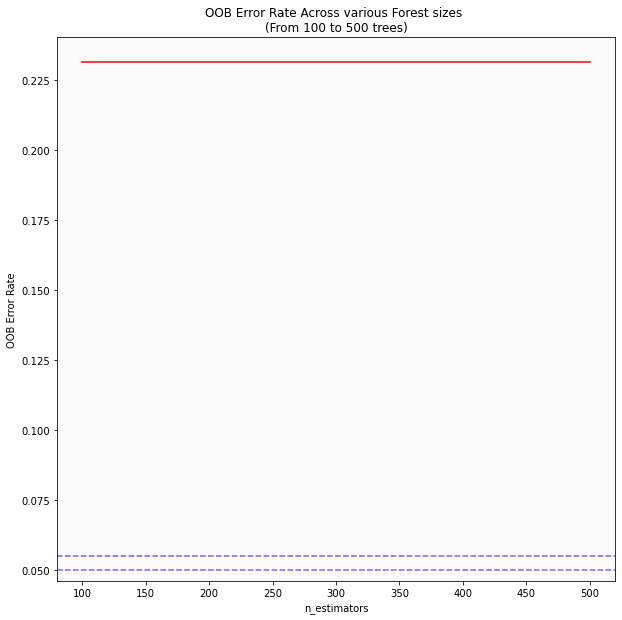

In [308]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.055, color='#875FDB',linestyle='--')
plt.axhline(0.05, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 100 to 500 trees)')

In [309]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

OOB Error rate for 400 trees is: 0.23128


In [310]:
# Refine the tree via OOB Output
rf.set_params(n_estimators=400,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(max_depth=2, n_estimators=400)

In [311]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_estimators=400)

In [312]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

In [313]:
predictions_rf = rf.predict(X_test)

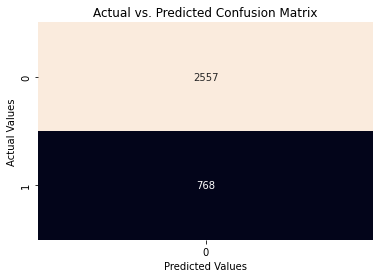

In [314]:
conf_mat = create_conf_mat(y_test, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

As we can see that the random forrest model is given very low accuracy. It is unable to predict any value as 1. So we will not use this model

Since we have class imbalance having more 0s than 1s in th target variable we do stratified shuffle to ensure that there is balance of data in training and testing data.

In [302]:
# Classification Model Function
# use StratifiedShuffleSplit()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5,
                             random_state=0)
sss.get_n_splits(X, y)
def classify(model, X, y):   ##########################building a function to be called by each model to split data ,fit it and do predictions
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Training the model
    model.fit(X_train, y_train)
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(y_test, pred)
    print("\nClassification Report:\n", class_report)
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    

In [111]:
# Decision Tree Classifier
model=DecisionTreeClassifier(random_state=21, max_depth=15)
classify(model, X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79      2557
           1       0.27      0.26      0.26       768

    accuracy                           0.67      3325
   macro avg       0.53      0.52      0.52      3325
weighted avg       0.66      0.67      0.67      3325

Cross Validation Score: 67.83458646616542


In [112]:
# Logistic Regression
model=LogisticRegression()
classify(model, X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      2557
           1       0.50      0.05      0.10       768

    accuracy                           0.77      3325
   macro avg       0.64      0.52      0.48      3325
weighted avg       0.71      0.77      0.69      3325

Cross Validation Score: 76.94736842105263


In [113]:
# Support Vector Classifier
model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model, X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      2557
           1       0.00      0.00      0.00       768

    accuracy                           0.77      3325
   macro avg       0.38      0.50      0.43      3325
weighted avg       0.59      0.77      0.67      3325

Cross Validation Score: 76.88721804511277


In [114]:
# K Neighbors Classifier
model=KNeighborsClassifier(n_neighbors=7)
classify(model, X, y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      2557
           1       0.36      0.13      0.19       768

    accuracy                           0.74      3325
   macro avg       0.57      0.53      0.52      3325
weighted avg       0.68      0.74      0.70      3325

Cross Validation Score: 74.22556390977444


Choosing a K Value
Let's go ahead and use the elbow method to pick a good K Value:

In [115]:
accuracy_rate = []

# May take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,data,data['Is_Churn'],cv=10)
    accuracy_rate.append(score.mean())

In [116]:
error_rate = []

# May take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,data,data['Is_Churn'],cv=10)
    error_rate.append(1-score.mean())

Text(0, 0.5, 'Accuracy Rate')

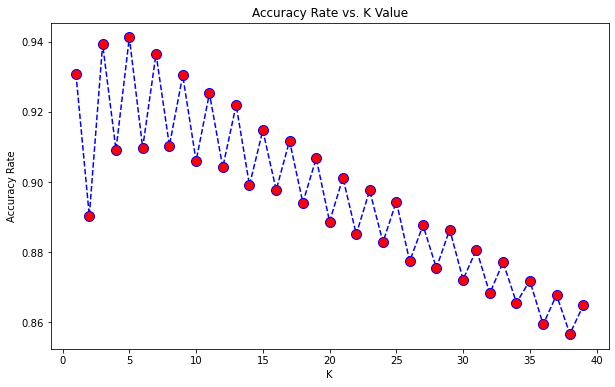

In [117]:
plt.figure(figsize=(10,6))
# plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
#         markerfacecolor='red', markersize=10)
# plt.title('Error Rate vs. K Value')
# plt.xlabel('K')
# plt.ylabel('Error Rate')

plt.plot(range(1,40),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

Here we can see that that after around K > 6 the error rate just tends to hover around 0.06-0.05 Let's retrain the model with that and check the classification report!

Also, in case of Accuracy, after around K > 6, the accuracy is also almost contant.

In [224]:

knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=3


[[2456  101]
 [ 701   67]]


              precision    recall  f1-score   support

           0       0.78      0.96      0.86      2557
           1       0.40      0.09      0.14       768

    accuracy                           0.76      3325
   macro avg       0.59      0.52      0.50      3325
weighted avg       0.69      0.76      0.69      3325



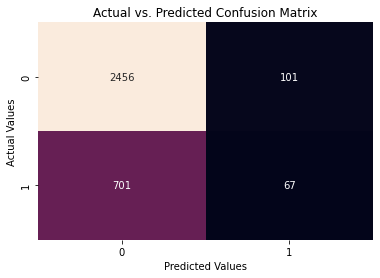

In [225]:
conf_mat = create_conf_mat(y_test, pred)##########plotting confusion matrix to see the accuracy
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

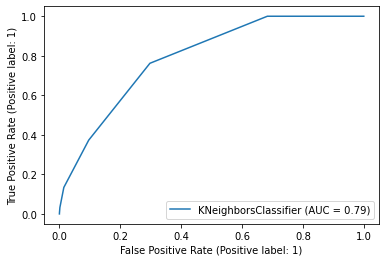

In [131]:

plot_roc_curve(knn,X =X_train, y= y_train)

In [273]:
# Grid search cross validation for logistic regression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
LR_model=GridSearchCV(logreg,grid,cv=10)
LR_model.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.7705235355837765


In [276]:
LR_model = LogisticRegression(C=10.0, penalty='l2', class_weight = 'balanced',max_iter=1000, random_state=123) 
LR_model.fit(X_train,y_train)####using class weight as balanced since there is imbalance in the classes

LogisticRegression(C=10.0, class_weight='balanced', max_iter=1000,
                   random_state=123)

In [277]:
pd.DataFrame(LR_model.predict_proba(X_train))

,0,1
0,0.387502,0.612498
1,0.534562,0.465438
2,0.717845,0.282155
3,0.587216,0.412784
4,0.461987,0.538013
...,...,...
3320,0.535403,0.464597
3321,0.521211,0.478789
3322,0.465435,0.534565
3323,0.285260,0.714740


In [278]:
prediction_train = pd.DataFrame(LR_model.predict_proba(X_train)) #### give me the predicted probabilities on X_train

In [279]:
###### Apply a threshold of 0.6 ######

prediction_train['predicted_classes_0.6'] = 0

prediction_train.loc[prediction_train[1]>=0.6, 'predicted_classes_0.6'] = 1

In [280]:
prediction_train

,0,1,predicted_classes_0.6
0,0.387502,0.612498,1
1,0.534562,0.465438,0
2,0.717845,0.282155,0
3,0.587216,0.412784,0
4,0.461987,0.538013,0
...,...,...,...
3320,0.535403,0.464597,0
3321,0.521211,0.478789,0
3322,0.465435,0.534565,0
3323,0.285260,0.714740,1


In [281]:
predictions = LR_model.predict(X_train)

In [282]:
pd.DataFrame({'Actuals' : y_train, 'precdictions': predictions})

,Actuals,precdictions
0,0,1
1,1,0
2,0,0
3,0,0
4,0,1
...,...,...
3320,0,0
3321,0,0
3322,0,1
3323,0,1


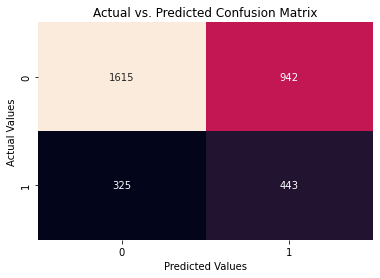

In [283]:
conf_mat = create_conf_mat(y_test, pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [284]:
pred = LR_model.predict(X_test)
    
# Classification Report
class_report = classification_report(y_test, pred)
print("\nClassification Report:\n", class_report)
# Cross Validation Score
cv_score = (cross_val_score(model, X, y, cv=5).mean())*100
print("Cross Validation Score:", cv_score)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.63      0.72      2557
           1       0.32      0.58      0.41       768

    accuracy                           0.62      3325
   macro avg       0.58      0.60      0.56      3325
weighted avg       0.71      0.62      0.65      3325

Cross Validation Score: 74.22556390977444


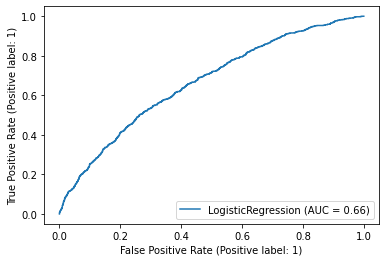

In [285]:
#### Plotting the roc curve for the model fit ####

plot_roc_curve(LR_model,X =X_train, y= y_train)

In [286]:
estimator_GB = GradientBoostingClassifier(max_features='auto', loss='deviance')
parameters_GB = {
    'learning_rate': (0.2, 0.3),
    'n_estimators': (100,130,5),              
    'subsample' : (0.2, 0.3, 0.4),
    'min_samples_split' : (0.1,0.2,0.3),
    'min_samples_leaf' : (3,4,5),
    'max_depth': (2,3,4), 
    
                }
# with GridSearch
grid_search_GB = GridSearchCV(
    estimator=estimator_GB,
    param_grid=parameters_GB,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

In [141]:
GB=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [142]:
GB.fit(X_train,y_train)

GradientBoostingClassifier(random_state=123)

In [143]:
y_pred_GB =GB.predict(X_test)

In [146]:
# #print(grid_search_GB.best_params_ ) 
# print(grid_search_GB.best_score_ ) 
GB.score(X_test, y_test)

0.7687218045112783

In [147]:
# Classification Report
class_report = classification_report(y_test, pred)
print("\nClassification Report:\n", class_report)
# Cross Validation Score
cv_score = (cross_val_score(model, X, y, cv=5).mean())*100
print("Cross Validation Score:", cv_score)


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.63      0.72      2557
           1       0.32      0.58      0.41       768

    accuracy                           0.62      3325
   macro avg       0.58      0.60      0.56      3325
weighted avg       0.71      0.62      0.65      3325

Cross Validation Score: 74.22556390977444


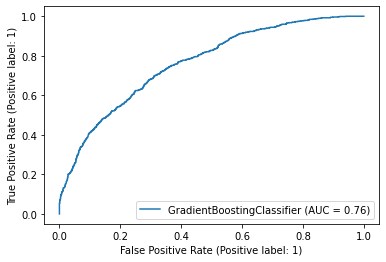

In [148]:
########Plotting ROC curve
plot_roc_curve(GB,X =X_train, y= y_train)

In [188]:
test_data=pd.read_csv('test_lTY72QC.csv')  ######loading testing data

In [189]:
test_data

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average
1,9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average
2,a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good
3,b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
4,dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good
...,...,...,...,...,...,...,...,...,...,...
2846,19e40adf,40,Female,10L - 15L,1338458.22,0,0,1,1,Poor
2847,52d5bc8d,48,Female,More than 15L,1448280.27,0,1,2,1,Average
2848,f708121b,59,Male,More than 15L,1100555.64,3,0,1,1,Poor
2849,f008715d,34,Female,5L - 10L,1502818.92,2,0,1,1,Poor


In [191]:
ID=test_data['ID'].values
test_data.drop(['ID'],axis=1,inplace=True)  ## removes specified columns as the number is different for each row and has no impact on the target

In [192]:
#converting income column in numeric by creating dummy columns
le = preprocessing.LabelEncoder() 
test_data['Income'] = le.fit_transform(test_data['Income'])
test_data['Income']

0       3
1       1
2       0
3       2
4       3
       ..
2846    0
2847    3
2848    3
2849    1
2850    0
Name: Income, Length: 2851, dtype: int32

In [193]:
#converting credit category column in numeric by using label encoder
test_data['Credit_Category'] = le.fit_transform(test_data['Credit_Category'])
test_data['Credit_Category']

0       0
1       0
2       1
3       2
4       1
       ..
2846    2
2847    0
2848    2
2849    2
2850    1
Name: Credit_Category, Length: 2851, dtype: int32

In [194]:
#converting gender column in numeric by creating dummy columns
testgender_dummies = pd.get_dummies(test_data['Gender'], drop_first=False, prefix = 'Gender')

test_data.drop(['Gender'],axis=1,inplace=True)

test_data = pd.concat([test_data,testgender_dummies],axis=1)
#test_data.shape()

In [195]:
#Capping the value of product holdings to 3 and creating dummy variables for product holdings
test_data.loc[test_data['Product_Holdings']== '3+','Product_Holdings'] = '3'

Product_Holdings_data = pd.get_dummies(test_data['Product_Holdings'],prefix ='Product_Holdings')

test_data.drop(['Product_Holdings'],axis=1,inplace=True)

test_data = pd.concat([test_data,Product_Holdings_data],axis=1)

In [196]:
test_data.head()  #########Taking a look at testing data

,Age,Income,Balance,Vintage,Transaction_Status,Credit_Card,Credit_Category,Gender_Female,Gender_Male,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3
0,50,3,1008636.39,2,1,1,0,1,0,0,1,0
1,36,1,341460.72,2,0,1,0,0,1,0,1,0
2,25,0,439460.10,0,0,1,1,1,0,0,1,0
3,41,2,28581.93,0,1,1,2,0,1,0,1,0
4,48,3,1104540.03,2,1,0,1,0,1,0,0,1


In [197]:
test_data.dtypes  #All columns have been converted  to numeric 

Age                     int64
Income                  int32
Balance               float64
Vintage                 int64
Transaction_Status      int64
Credit_Card             int64
Credit_Category         int32
Gender_Female           uint8
Gender_Male             uint8
Product_Holdings_1      uint8
Product_Holdings_2      uint8
Product_Holdings_3      uint8
dtype: object

In [198]:
#scaling age and income variables
#list for cols to scale
cols_to_scale_test = ['Age','Balance']

#create and fit scaler
scaler = StandardScaler()
scaler.fit(test_data[cols_to_scale_test])

#scale selected data
test_data[cols_to_scale_test] = scaler.transform(test_data[cols_to_scale_test])
test_data.head()

,Age,Income,Balance,Vintage,Transaction_Status,Credit_Card,Credit_Category,Gender_Female,Gender_Male,Product_Holdings_1,Product_Holdings_2,Product_Holdings_3
0,0.909802,3,0.378469,2,1,1,0,1,0,0,1,0
1,-0.546246,1,-0.892080,2,0,1,0,0,1,0,1,0
2,-1.690283,0,-0.705453,0,0,1,1,1,0,0,1,0
3,-0.026229,2,-1.487916,0,1,1,2,0,1,0,1,0
4,0.701795,3,0.561105,2,1,0,1,0,1,0,0,1


In [320]:
y_pred_GB =LR_model.predict(X)###After trying out predictions with different models we find that logistic regression is giving the maximum accuracy

In [319]:
#Creating the csv file to submit final predictions
submit_df = pd.DataFrame()
submit_df['ID'] = ID
submit_df['Is_Churn'] = y_pred_GB
submit_df.to_csv('Solutions.csv', index= False) 

In [317]:
#
df = pd.DataFrame(y_pred_GB, columns = ['Is_Churn'])
df
df['Is_Churn'].value_counts()

0    2851
Name: Is_Churn, dtype: int64

In [322]:
class_report = classification_report(y, y_pred_GB)
print("\nClassification Report:\n", class_report)
# Cross Validation Score
cv_score = (cross_val_score(model, X, y, cv=5).mean())*100
print("Cross Validation Score:", cv_score)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.63      0.72      5113
           1       0.32      0.58      0.42      1537

    accuracy                           0.62      6650
   macro avg       0.58      0.61      0.57      6650
weighted avg       0.72      0.62      0.65      6650

Cross Validation Score: 74.22556390977444


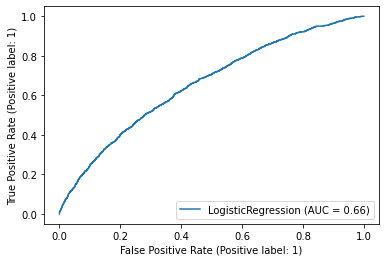

In [323]:

plot_roc_curve(LR_model,X =X, y= y)